<a href="https://colab.research.google.com/github/GenAIUnplugged/tensorflow_series/blob/main/transfer_learning_image_dataset_from_directory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir ~/.kaggle

In [4]:
!ls /content/drive/MyDrive/

'Classical Machine Learning'   kaggle.json		 Tensorflow
'Colab Notebooks'	       langchain		 Trading
 EDA			       LangGraph		 Untitled0.ipynb
 fastapi		      'Machine Learninig'	 Valeo
 GenerativeAI		       PyTorch
'Kaggle Dataset Colab.gdoc'   'Reinforcement Learning'


In [5]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download imsparsh/flowers-dataset

Dataset URL: https://www.kaggle.com/datasets/imsparsh/flowers-dataset
License(s): CC0-1.0
 61% 125M/205M [00:00<00:00, 1.31GB/s]
100% 205M/205M [00:00<00:00, 870MB/s] 


In [7]:
!unzip flowers-dataset.zip -d flowers

Archive:  flowers-dataset.zip
  inflating: flowers/LICENSE.txt     
  inflating: flowers/Testing_set_flower.csv  
  inflating: flowers/sample_submission.csv  
  inflating: flowers/test/Image_1.jpg  
  inflating: flowers/test/Image_10.jpg  
  inflating: flowers/test/Image_100.jpg  
  inflating: flowers/test/Image_101.jpg  
  inflating: flowers/test/Image_102.jpg  
  inflating: flowers/test/Image_103.jpg  
  inflating: flowers/test/Image_104.jpg  
  inflating: flowers/test/Image_105.jpg  
  inflating: flowers/test/Image_106.jpg  
  inflating: flowers/test/Image_107.jpg  
  inflating: flowers/test/Image_108.jpg  
  inflating: flowers/test/Image_109.jpg  
  inflating: flowers/test/Image_11.jpg  
  inflating: flowers/test/Image_110.jpg  
  inflating: flowers/test/Image_111.jpg  
  inflating: flowers/test/Image_112.jpg  
  inflating: flowers/test/Image_113.jpg  
  inflating: flowers/test/Image_114.jpg  
  inflating: flowers/test/Image_115.jpg  
  inflating: flowers/test/Image_116.jpg  
  inf

In [8]:
training_path = "/content/flowers/train/"
testing_path = "/content/flowers/test/"

Found 2746 files belonging to 5 classes.
Found 924 files.
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 96ms/step - accuracy: 0.6248 - loss: 0.9958
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8734 - loss: 0.3779
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9146 - loss: 0.2764
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9454 - loss: 0.1911
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9553 - loss: 0.1755
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 271ms/step


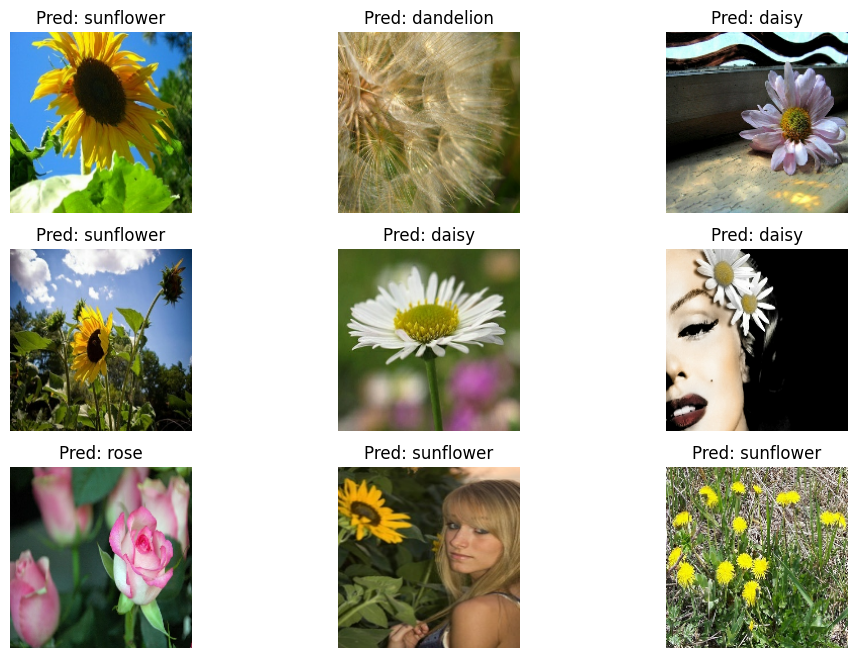

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Settings
BATCH_SIZE = 32
IMG_SIZE = (180, 180)
AUTOTUNE = tf.data.AUTOTUNE

# Step 1: Load Raw Training Dataset
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    training_path,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=123
)

# Save class names before preprocessing
class_names = raw_train_ds.class_names
num_classes = len(class_names)

# Step 2: Preprocess and Optimize Training Dataset
train_ds = (
    raw_train_ds
    .map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(1000)
    .prefetch(buffer_size=AUTOTUNE)
)

# Step 3: Load and Preprocess Test Dataset (No labels)
raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    testing_path,
    labels=None,
    label_mode=None,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

test_ds = (
    raw_test_ds
    .map(lambda x: preprocess_input(x), num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

# Step 4: Build ResNet50V2 Model
base_model = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False  # Freeze base model

inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# Step 5: Compile Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 6: Train Model
history = model.fit(train_ds, epochs=5)  # Adjust epochs as needed

# Step 7: Predict on Test Data
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

# Step 8: Show Sample Predictions
plt.figure(figsize=(12, 8))
for images in raw_test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_label = class_names[predicted_classes[i]]
        plt.title(f"Pred: {pred_label}")
        plt.axis("off")
plt.show()


In [15]:
loss, accuracy = model.evaluate(train_ds)
print(f"Train Accuracy: {accuracy:.2%}")


86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9585 - loss: 0.1573
Train Accuracy: 96.18%
